(ch2:prepare)=
# Prepare the Data for Network Algorithms

Next, it's time for us to prepare our networks for machine learning algorithms. Like before, you are going to try to capture most of these with functions. This is because:
1. Functions will make the useful data preparation code that we write usable on new networks,
2. You will gradually build libraries of utility functions that we can prepare together into packages of their own or recycle for future projects,
3. You can use modularize these functions into other parts of your data pipeline before it gets to your algorithm, to keep a lean module-oriented design,
4. You can easily try different transformations of the data and evaluate which ones tend to work best.

First, let's re-load the data that we have read in from the previous section:

In [1]:
import os
import urllib
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from graspologic.utils import import_edgelist
import numpy as np
import glob

# the AWS bucket the data is stored in
BUCKET_ROOT = "open-neurodata"
parcellation = "Schaefer400"
FMRI_PREFIX = "m2g/Functional/BNU1-11-12-20-m2g-func/Connectomes/" + parcellation + "_space-MNI152NLin6_res-2x2x2.nii.gz/"
FMRI_PATH = os.path.join("datasets", "fmri")  # the output folder
DS_KEY = "abs_edgelist"  # correlation matrices for the networks to exclude

def fetch_fmri_data(bucket=BUCKET_ROOT, fmri_prefix=FMRI_PREFIX,
                    output=FMRI_PATH, name=DS_KEY):
    """
    A function to fetch fMRI connectomes from AWS S3.
    """
    # check that output directory exists
    if not os.path.isdir(FMRI_PATH):
        os.makedirs(FMRI_PATH)
    # start boto3 session anonymously
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    # obtain the filenames
    bucket_conts = s3.list_objects(Bucket=bucket, 
                    Prefix=fmri_prefix)["Contents"]
    for s3_key in bucket_conts:
        # get the filename
        s3_object = s3_key['Key']
        # verify that we are grabbing the right file
        if name not in s3_object:
            op_fname = os.path.join(FMRI_PATH, str(s3_object.split('/')[-1]))
            if not os.path.exists(op_fname):
                s3.download_file(bucket, s3_object, op_fname)

def read_fmri_data(path=FMRI_PATH):
    """
    A function which loads the connectomes as adjacency matrices.
    """
    # import edgelists with graspologic
    # edgelists will be all of the files that end in a csv
    networks = [import_edgelist(fname) for fname in glob.glob(os.path.join(path, "*.csv"))]
    return networks

In [2]:
fetch_fmri_data()
As = read_fmri_data()

In [3]:
A = As[0]

## Data cleaning

Most network machine learning algorithms cannot work with a node which is *isolated*, a term we will learn in [Chapter 4](#link?) which means that the node has no edges. Let's start with fixing this. We can remove isolated nodes from the network as follows:
1. Compute the number of nodes each node connects to. This consists of summing the matrix along the rows (or columns). The network is *undirected*, a property you will learn in [properties of networks](ch4:prop-net), which means that if a node can communicate with another node, that other node can also communicate with that node
2. Identify any nodes which are connected to zero nodes along either the rows or columns. These are the *isolated* nodes.
3. Remove the isolated nodes from the adjacency matrix.

Let's see how this works in practice. We begin by first taking the row sums of each node, which tells us how many nodes that each node is connected to. Next, we remove all nodes with are not connected to any other nodes (the row and column sum are both zero) from both the adjacency matrix and the labels:

In [4]:
def remove_isolates(A):
    """
    A function which removes isolated nodes from the 
    adjacency matrix A.
    """
    degree = A.sum(axis=0)  # sum along the rows to obtain the node degree
    out_degree = A.sum(axis=1)
    A_purged = A[~(degree == 0),:]
    A_purged = A_purged[:,~(degree == 0)]
    print("Purging {:d} nodes...".format((degree == 0).sum()))
    return A_purged

In [5]:
A = remove_isolates(A)

Purging 0 nodes...


So no isolated nodes were found, and consequently no nodes were purged. Great! What else can we do?

It turns out that a common thing to do with functional MRI connectomes is to, in fact, not look at the correlations themselves, but the *absolute correlations*. The intuition here is that, if one node is less active when another node is active, that *kind of* indicates that they are still operating together, right? Let's take a look at how we can compute the absolute correlations:

<AxesSubplot: title={'center': 'Difference(Absolute - Raw)'}>

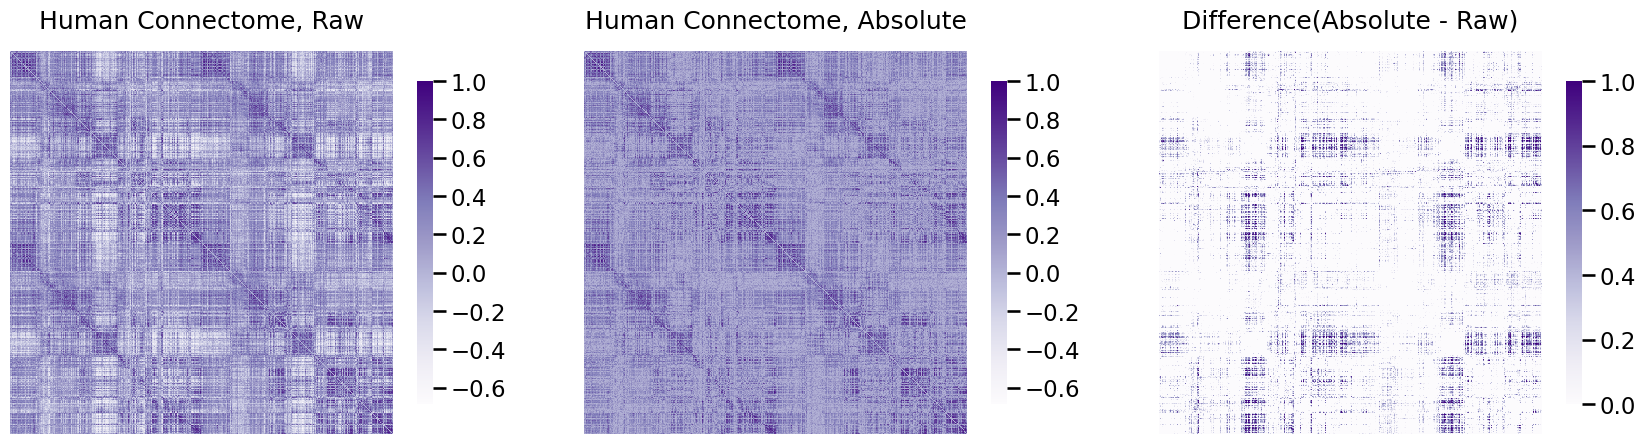

In [6]:
import matplotlib.pyplot as plt
from graphbook_code import heatmap

A_abs = np.abs(A)
fig, axs = plt.subplots(1,3, figsize=(21, 6))
heatmap(A, ax=axs[0], title="Human Connectome, Raw", vmin=np.min(A), vmax=1)
heatmap(A_abs, ax=axs[1], title="Human Connectome, Absolute", vmin=np.min(A), vmax=1)
heatmap(A_abs - A, ax=axs[2], title="Difference(Absolute - Raw)", vmin=0, vmax=1)

As you can see in the right-most plot, a good chunk of the values changed, which is indicated by larger differences from the raw to the real data.

To streamline the process of cleaning up the raw data, you will often need to write custom data cleaners. You will want your cleaners to work seamlessly with `sklearn`'s functions, such as pipelines, and will require you to only implement three class methods: `fit()`, `transform()`, `fit_transform()`. By adding `TransformerMixin` as a base class, we do not even have to implement the third one! If we use `BaseEstimator` as a base class, we will also obtain `get_params()` and `set_params()`, which will be useful for hyperparameter tuning steps you might need in other settings. For example, here is an example cleaner class which purges the adjacency matrix of isolates and remaps the categorical labels to numbers. Note that a key step to implementing this all as cleanly as possible is that the inputs, an adjacency matrix and a vector of node labels, are passed in as a *single* tuple object. This is because `sklearn` anticipates that the return arguments from calls of `transform()` can be passed sequentially to one another, which we will see later on when we try to string several of these transformers together into a single pipeline:

In [7]:
from sklearn.base import TransformerMixin, BaseEstimator

class CleanData(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X):
        return self

    def transform(self, X):
        print("Cleaning data...")
        Acleaned = remove_isolates(X)
        A_abs_cl = np.abs(Acleaned)
        self.A_ = A_abs_cl
        return self.A_

data_cleaner = CleanData()
A_clean = data_cleaner.transform(A)

Cleaning data...
Purging 0 nodes...


## Edge weight transformations

One of the most important transformations that we will come across in network machine learning is called *edge-weight transformation*. Many networks you enounter, such as the human diffusion connectome, will have edge weights which do not just take values of 1 or 0 (edge or no edge, a *binary* network); rather, many of the networks you come across may have discrete-weighted edges (the edges take non-negative inter values, such as 0, 1, 2, 3, ...), or decimal-weight edges (the edges take values like 0, 0.1234, 0.234, 2.4234, ...). For a number of reasons discussed later in [Regularization](ch4:regularization), this is often not really a desirable characteristic.  The edges in a network might be error prone, and it might only be desirable to capture one (or a few) properties about the edge weights, rather than just leave them in their raw values. Further, a lot of the techniques we come across throughout this book might not even *work* on networks which are not binary. For this reason, we need to get accustomed to transforming the edge weights to take new sets of values.

There are two common approaches to transform edge weights: the first is called binarization (set all of the edges to take a value of 0 or 1), and the second is called an ordinal transformation. 

### Binarization of edges 

Binarization is quite simple: the edges in the raw network take non-binary values (values other than just 0s and 1s), and you need them to be 0s and 1s for your algorithm. How do you solve this? 

The simplest thing to do is usually to just look at which edges take a value of zero, and keep them as zero, and then look at all of the edges which take a non-zero value, and set them to one. In effect, what this does is it just takes the original non-binary network, and converts it to a binary one. Let's take a look at how we can implement this using `graspologic`. We first look at the network before binarization, and then after:

In [8]:
from graspologic.utils import binarize

threshold = 0.4
A_bin = binarize(A_clean > threshold)

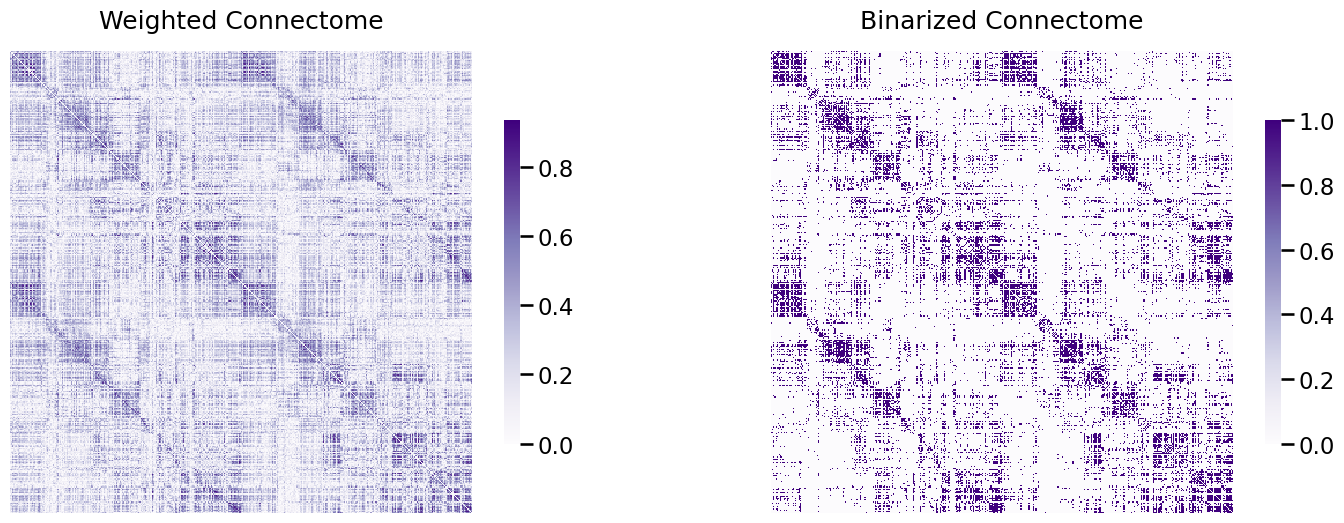

In [9]:
fig, ax = plt.subplots(1,2, figsize=(18, 6))
heatmap(A_clean, ax=ax[0], title="Weighted Connectome")
heatmap(A_bin, ax=ax[1], title="Binarized Connectome");

Woah! That heatmap looks a whole lot different, particularly along the off-diagonal (the lower left and upper right corners). What happened was, a lot of the higher edge-weights tend to be concentrated around the diagonal (the weird, slightly blocky, looking shapes) so by binarizing, we removed many of the small edge weights that are not as close to the diagonal.

Another way we could have normalized these edge weights is through something called a *pass to ranks*. Through a pass to ranks, the edge weights are discarded entirely, with one exception: the edges which are non-zero are first ranked, from smallest to largest, with the largest item having a rank of one, and the smallest item having a rank of $\frac{1}{\text{number of non-zero edges}}$. This is called an *ordinal transformation*, in that it preserves the *orders* of the edge-weights, but discards all other information. 

In [10]:
from graspologic.utils import pass_to_ranks

A_ptr = gp.utils.pass_to_ranks(A_clean)

NameError: name 'gp' is not defined

Again, we plot the resulting connectome, before and after passing to ranks, as heatmaps:

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 6))
heatmap(A_clean, ax=ax[0], title="Weighted connectome")
heatmap(A_bin, ax=ax[1], title="Binary connectome")
heatmap(A_ptr, ax=ax[2], title="Ranked connectome", vmin=0, vmax=1);

This has shifted the histogram of edge-weights, as we can see below:

In [ ]:
import seaborn as sns


fig, ax = plt.subplots(2,1, figsize=(10, 10))
sns.histplot(A_clean[A_clean > 0].flatten(), ax=ax[0]);
ax[0].set_xlabel("Edge weight")
ax[0].set_title("Histogram of human connectome non-zero edge weights");

sns.histplot(A_ptr[A_ptr > 0].flatten(), ax=ax[1]);
ax[1].set_xlabel("ptr(Edge weight)")
ax[1].set_title("Histogram of human connectome, passed-to-ranks");

This has the desirable property that it bounds the network's edge weights to be between $0$ and $1$, as we can see above, which is often crucial if we seek to compare two or more networks and the edge weights are relative in magnitude (an edge's weight might mean something in relation to another edge's weight in that same network, but an edge's weight means nothing in relation to another edge's weight in a separate network). Further, passing to ranks is not very susceptible to outliers, as we will see in later chapters. 

Again, we will turn the edge-weight transformation step into its own class, much like we did above:

In [ ]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        print("Scaling edge-weights...")
        A_scaled = gp.utils.pass_to_ranks(X)
        return (A_scaled)
    
feature_scaler = FeatureScaler()
A_cleaned_scaled = feature_scaler.transform(A_clean)

### Transformation pipelines

As you can see, there are a number of data transformations that need to be executed to prepare network data for machine learning algorithms. One thing that might be desirable is to develop a pipeline which automates the data preparation process for you. We will perform this using the `Pipeline` class from `sklearn`. The `Pipeline` class can help us apply sequences of transformations. Here is a simple pipeline for doing all of the steps we have performed so far:

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('cleaner', CleanData()),
    ('scaler', FeatureScaler()),
])

A_xfm = num_pipeline.fit_transform(A)

The pipeline class takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers, which implement the `fit_transform()` method. In our case, this is handled directly by the `TransformerMixin` base class.

When you call the `fit_transform()` method of the numerical pipeline, it calls the `fit_transform()` method on each of the transformers, and passes the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the `fit()` method. 

Next, we'll see the real handiness of the `Pipeline` module. The reason we went to lengths to define a pipeline was that we wanted to have an easily reproducible procedure that we could efficiently apply to new connectomes. Let's see how easy it is to apply to the second subject in our dataset:

In [ ]:
A_xfm2 = num_pipeline.fit_transform(As[1])

Next, we visualize the connectome, after transformation:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
heatmap(As[0], title="Connectome 2, Raw", ax=axs[0], vmin=np.min(As[0]), vmax=1)
heatmap(A_xfm2, title="Connectome 2, Preprocessed", ax=axs[1], vmin=0, vmax=1);

Voila!